In [129]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

# first used in exercise one
import midterm as mt
from sklearn import preprocessing # for scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# first used in exercise two
from sklearn.decomposition import PCA

In [130]:
# import importlib
# importlib.reload(mt)

# Exercise One

## Derive the coordinate minimization formula

![firstpage](cmm1.png)

![secondpage](cmm2.png)

![thirdpage](cmm3.png)

## Implement coordinate descent

I've submitted my implementation in the midterm.py file. I use this implementation in this notebook - I imported the module above and gave it the alias 'mt'. In addition, in case it helps understand how my implementation works, I've included the tests I wrote as part of doing the implementation. These are in the file midterm-test.py.

In more detail, here's where the requested functions are implemented in midterm.py:

* *Write a function that computes the solution to the partial minimization problem.* See the function minimize_beta_term (which calls the a_term and c_term functions).
* *Write a function computeobj that computes and returns F(β) for any β.* See the function elasticnet_objective.
* *Write a function cycliccoorddescent that implements the cyclic coordinate descent algorithm. The function takes as input the initial point and the maximum number of iterations. The stopping criterion is the maximum number of iterations.* See the function cycliccoorddescent. This function calls the function coorddescent, which handles the the main algorithm for both cyclic and random implementations - this function passes a sequential set of j values.
* *Write a function pickcoord that samples uniformly from the set {1, . . . , d} .* I implemented this functionality in the get_sequence_of_js function. This function returns a list of values that define the specific beta values/coefficients to be minimized. When called with the random parameter equal to False, the function returns a sequential list of j values (i.e., [1 2 3 1 2 3 ...]). When called with random equal to True, the function samples uniformly from the set {1,...,d} and returns a list of j values built from these random selections.
* *Write a function randcoorddescent that implements the randomized coordinate descent algo- rithm. The function takes as input the initial point and the maximum number of iterations. The stopping criterion is the maximum number of iterations.* See the function randcoorddescent. This function calls the function coorddescent, which handles the the main algorithm for both cyclic and random implementations - this function passes a set of j values that have been randomly chosen.

## Load and standardize data

*Consider the Hitters dataset from [2]. You may download it from [here](https://raw. githubusercontent.com/selva86/datasets/master/Hitters.csv). Standardize the data (i.e., center the predictors and the outputs and divide them by their standard deviations).*

In [131]:
h = pd.read_csv('Hitters.csv')
h.shape

(322, 20)

In [132]:
h.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')

In [133]:
# remove rows w/ empty values - i think this is only those w/ no salary
h = h.dropna()
h.shape

(263, 20)

In [134]:
# convert categorical vars to dummy variables
h = pd.get_dummies(h)
h.shape

(263, 23)

In [135]:
h[:1]

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1


In [136]:
# split into features and the value to predict (X and y)
# scale all features so each col has mean zero and std 1
X_scaled = preprocessing.scale(h.drop('Salary', axis=1))
y_scaled = preprocessing.scale(h['Salary']) 

(X_scaled.shape, y_scaled.shape)

((263, 22), (263,))

## Find best lambda via cross-validation

*In the remainder, the iteration counter iter refers here to t/d, that is the effective number of passes over all coordinates. Set the maximum number of iterations to 1000. Set α = 0.9. Run your own implementation of cross-validation on the Hitters dataset to find the optimal value of λ.*

My best value of lambda, from my own cross-validation implementation using MSE, is shown below.

In [137]:
# 1000 is a lot, but it's what the problem specifies; multiply by the number
# of features to get to an effective number of iterations of 1000; note also
# that per the discussion board we can choose a smaller number if we get to 
# convergence (I use a smaller number during cross-validation)
feature_count = X_scaled.shape[1] 
actual_iteration_count = 1000 * feature_count
(feature_count, actual_iteration_count)

(22, 22000)

In [138]:
def train_and_test_single_fold(X_full, y_full, train_index, test_index, lam, alpha, beta0=None):
    """
    Train using the data identified by the indices in train_index, and then test
    (and return MSE) using the data identified by the indices in test_index.
    """
    beta_vals = mt.randcoorddescent(X_full[train_index], y_full[train_index], 
                                    lam, alpha, max_iter=500, beta0=beta0)

    final_coefs = mt.get_final_coefs(beta_vals)
    
    return mean_squared_error(y_full[test_index], X_full[test_index].dot(final_coefs))

In [139]:
def train_and_test_for_all_folds(X_full, y_full, train_indices, test_indices, lam, alpha):
    """
    Train and test for all folds - for now, 10 folds, hard-coded. Return the mean of the 
    set of MSE values from all folds."""
    mses = [train_and_test_single_fold(X_full, y_full, 
                                       train_indices[i], test_indices[i], lam, alpha) for i in range(10)]
    return(np.mean(mses))

In [140]:
# get arrays with 10 sets of test and train indices - one for each fold
kf = KFold(10, shuffle=True, random_state=42)

train_indices_list = []
test_indices_list = []
for train_index, test_index in kf.split(X_scaled):
    train_indices_list.append(train_index)
    test_indices_list.append(test_index)
    
train_indices = np.array(train_indices_list)
test_indices = np.array(test_indices_list)

In [141]:
lambdas = np.logspace(-5, 0.1, num=10)
lambdas

array([  1.00000000e-05,   3.68694506e-05,   1.35935639e-04,
         5.01187234e-04,   1.84784980e-03,   6.81292069e-03,
         2.51188643e-02,   9.26118728e-02,   3.41454887e-01,
         1.25892541e+00])

In [142]:
alpha = 0.9

In [143]:
# and finally, do 10-fold cross validation for each value of lambda, and
# show the mean of each set's MSEs
mses_by_lambda = [train_and_test_for_all_folds(X_scaled, y_scaled, 
                        train_indices, test_indices, lam, alpha) for lam in lambdas]
list(zip(lambdas, mses_by_lambda))

[(1.0000000000000001e-05, 0.5564141819182381),
 (3.6869450645195736e-05, 0.56579255935647643),
 (0.00013593563908785255, 0.56176060731687394),
 (0.00050118723362727253, 0.55447248022397366),
 (0.0018478497974222907, 0.55604922128375844),
 (0.0068129206905796083, 0.56006598415882003),
 (0.025118864315095794, 0.56602121278760953),
 (0.092611872812879373, 0.57708114844317915),
 (0.34145488738336005, 0.63552501573478071),
 (1.2589254117941673, 0.99170675337388681)]

Since a number of lambda values have very close to the same low average MSE, I'll choose 0.006812, which is the largest value of lambda - leading potentially more zeroed-out coefficients and so a simploer model - that has effectively the (same) lowest average MSE. 

In [145]:
best_lam = 0.0068129206905796083

## Run both implementations using the best value of lambda

*Run cycliccoorddescent and randcoorddescent on the training set of the Hitters dataset for that value of λ found by your own implementation of cross-validation. Plot the curves of the objective values F(βt) for both algorithms versus the iteration counter iter (use different colors). What do you observe?*

The curves of the objective function for the cyclic and random versions of my implementation are below. Zoomed out - with 22,000 iterations - they look the same. When I zoom in and only show the first 25 effective iterations it's easier to see that the random coordinate descent implementation drops to something closer to the lowest objective function value more quickly.

In [146]:
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_scaled,
                                                            y_scaled,
                                                            test_size=0.10, 
                                                            random_state=42)

In [147]:
betas_cyclic = mt.cycliccoorddescent(X_scaled, y_scaled, best_lam, alpha, 
                                     max_iter=actual_iteration_count)
mt.get_final_coefs(betas_cyclic)

array([-0.59483499,  0.63289046,  0.01226144, -0.01836527,  0.        ,
        0.25394428, -0.09559509, -0.17218187,  0.        ,  0.07080355,
        0.67276549,  0.35166678, -0.38771906,  0.17399649,  0.08186762,
       -0.03939991, -0.02816504,  0.01712241,  0.08223151, -0.04888765,
        0.00337635, -0.00250086])

In [148]:
betas_random = mt.randcoorddescent(X_scaled, y_scaled, best_lam, alpha,
                                   max_iter=actual_iteration_count)
mt.get_final_coefs(betas_random)

array([-0.59494834,  0.63297514,  0.01223474, -0.01830823,  0.        ,
        0.25394882, -0.0956927 , -0.1713451 ,  0.        ,  0.07106199,
        0.6722035 ,  0.35121048, -0.38767635,  0.1740001 ,  0.08184911,
       -0.03939844, -0.0295728 ,  0.01570117,  0.10150963, -0.02958121,
        0.00482197, -0.00104587])

In [149]:
obj_values = pd.DataFrame({
    'cyclic': betas_cyclic.apply(lambda r: mt.elasticnet_objective(r.as_matrix(),
                                    X_scaled, y_scaled, best_lam, alpha), axis=1),
    'random': betas_random.apply(lambda r: mt.elasticnet_objective(r.as_matrix(),
                                    X_scaled, y_scaled, best_lam, alpha), axis=1)
})
obj_values[:3]

,cyclic,random
0,1.000000,1.000000
1,0.846672,0.964134
2,0.843278,0.963996


In [150]:
def only_full_iterations(df):
    """Return a filtered dataframe with only rows for 
    complete iterations."""
    return df[::feature_count].reset_index(drop=True)

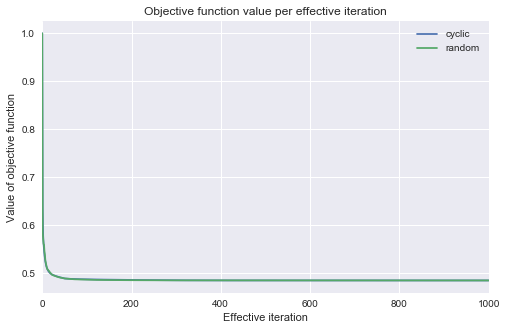

In [151]:
ax = only_full_iterations(obj_values).plot(title="Objective function value per effective iteration")
ax.set_xlabel("Effective iteration")
ax.set_ylabel("Value of objective function")

It's hard to see if the random implementation converges more quickly in the above plot because so much of the plot shows a flat line. I'm curious, so I'll plot just the first iterations here.

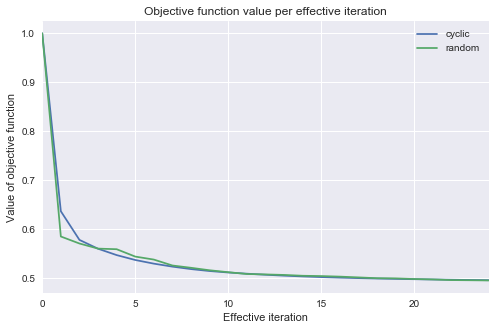

In [152]:
ax = only_full_iterations(obj_values)[:25].plot(title="Objective function value per effective iteration")
ax.set_xlabel("Effective iteration")
ax.set_ylabel("Value of objective function")

## Optimize implementation

*In [1] Section 4.5.2 p. 113-114 two strategies are proposed to speed up the computations: covariance updating
and warm start. Implement either of these (or both, if you are motivated) to speed up your own algorithm*

I'm implementing the warm start optimization here. I've updated my coordinate descent implementation takes an optional parameter called beta0 that, if provided, is used as the starting value for the coefficients (if not provided, the implementation just uses the zero vector, as it did without warm start).

First, we need to get $\lambda_0$, which I believe is the largest lambda value that doesn't yield an empty model with all coefficients zeroed out.

In [153]:
lam0 = (1 / len(X_scaled)) * np.max(X_scaled.T.dot(y_scaled))
lam0

0.56696568561765237

Note: If I try a value just about the above lambda I think the text is saying i should get a zero model... I don't. the above gives me about four non-zero coefficients (with an alpha of 1 so i'm full-on lasso with my elastic net implementation), and I can go up a bit further before I get to all zero coefficients. Why? I could be calculating the lambda_0 value incorrectly somehow, or not using it with my implementation correctly, or have an implementation with other errors, or something else.

So, we'll get our set of warm start lambda values starting at $\lambda_0$ and going to nearly zero. The numpy logspace function takes the base 10 exponents as params, so we use np.log10 to convert our $\lambda_0$ and nearly zero values before calling logspace.

In [154]:
warmstart_lambdas = np.logspace(np.log10(lam0), np.log10(1e-10), num=10)
warmstart_lambdas

array([  5.66965686e-01,   4.67550197e-02,   3.85566874e-03,
         3.17959045e-04,   2.62206017e-05,   2.16229091e-06,
         1.78314061e-07,   1.47047302e-08,   1.21263062e-09,
         1.00000000e-10])

And then we can get a set of coefficients for each value of lambda, using the coefficients for the previous lambda as the warm start coefficient for each subsequent value of lambda.

Note that with the current coordinate descent implementation, which uses only the number of iterations as a stopping point, this warm start approach won't actually in the end speed things up. To take advantage of the starting coefficients that are closer to the converged coefficients, I would need to update the stopping criteria with something that stops quickly if the solution has already converged - for example, code that looks at how much the objective value is changing and stops when the delta becomes very small.

In [155]:
starting_beta = np.zeros(feature_count) # start at zero the first time

for lam in warmstart_lambdas:
    # use 1 for elastic net to get full on lasso, at least for this experiment
    beta_vals = mt.randcoorddescent(X_scaled, y_scaled, lam, 1, beta0=starting_beta)
    final_coefs = mt.get_final_coefs(beta_vals)
    print("lambda: {}".format(lam))
    print(final_coefs)
    
    # and use the current final coefs as the starting point for the next lambda val
    starting_beta = final_coefs

lambda: 0.5669656856176524
[ 0.          0.07829781  0.          0.          0.          0.03164642
  0.          0.          0.          0.          0.06154196  0.1991093   0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.        ]
lambda: 0.046755019708188884
[ 0.          0.1993938   0.          0.          0.          0.10995739
  0.          0.          0.03860334  0.03161367  0.13170916  0.25890056
  0.          0.1451513   0.         -0.00970549 -0.00111211  0.01829923
  0.         -0.12740611  0.          0.        ]
lambda: 0.003855668735104611
[-0.38939575  0.43266743 -0.00364565  0.03995799  0.01745007  0.19489505
 -0.14431893 -0.05871347  0.17946699  0.07965743  0.28271344  0.31462135
 -0.20369387  0.16799404  0.07125795 -0.05310011 -0.03126487  0.02428829
  0.01675967 -0.12356384  0.00935441 -0.01008866]
lambda: 0.0003179590445613576
[-0.55503002  0.55186506  0.00508953  0.02028719  0.00702656  0.25192015
 -0.14866316 -0.12462

# Exercise two

## Generate simulated data

*Generate a simulated data set with 50 examples in each of 5 classes, i.e. 250 observations total. Each example should have 50 features. Be sure to add a mean shift to the observations in each class so that there are five distinct classes.*

In [156]:
num_examples = 50
num_features = 50
mean_vals = [0, 1.5, 3, 4.5, 6]
np.random.seed(42)
d = pd.DataFrame(np.vstack([np.random.normal(mean, 
                 size=(num_examples,num_features)) for mean in mean_vals]))
d.insert(0, 'Class', np.repeat(['A','B','C','D','E'], num_examples))
d.shape

(250, 51)

In [157]:
d[:1]

,Class,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,A,0.496714,-0.138264,0.647689,1.52303,-0.234153,-0.234137,1.579213,0.767435,-0.469474,...,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.76304


In [158]:
d_values = d.values[:, 1:num_features+1].astype('float')
d_values_centered = preprocessing.scale(d_values, with_std=False)
d_values_centered.shape

(250, 50)

In [159]:
d_values_centered[0]

array([-2.49620261, -3.11054553, -2.31122118, -1.42769024, -3.1806612 ,
       -3.17597982, -1.40108378, -2.29299655, -3.4443487 , -2.61552864,
       -3.49037565, -3.54287502, -2.70697955, -4.78506828, -4.8221139 ,
       -3.55230636, -4.15546401, -2.66594363, -3.92061749, -4.49926869,
       -1.68856949, -3.21782653, -2.81979138, -4.42437696, -3.54725713,
       -2.82765915, -4.06061019, -2.68364608, -3.60194582, -3.25672432,
       -3.60772055, -1.14535976, -2.9694022 , -4.07131093, -2.18567134,
       -4.22753792, -2.7918389 , -4.84700507, -4.30689878, -2.83616755,
       -2.15937416, -2.89229984, -3.12960253, -3.22224917, -4.50609712,
       -3.73388198, -3.41045607, -1.92783009, -2.64283395, -4.72147284])

## Compute principal component vectors and compare to sklearn

*Modify your normalized Oja algorithm to output the average of the final ten iterations. Use your own normalized Oja algorithm to compute the first 3 principal component vectors on the 250 observations. Compare your results to the ones obtained with scikit-learn’s PCA algorithm. Print the principal components from both your Oja algorithm and from scikit- learn.*

I modified my implementation to return the average of the final ten iterations for each principal component vector. The implementation is in the already-imported midterm module, aliased as 'mt'. The top-level function in the implementation is oja_fit, which takes the data and a number of components, and calls oja and deflate appropriately so that it can return the requested set of principal component vectors (and, in the new-and-improved code, the eigenvalues and all lambda values).

My vectors aren't the same as the vectors returned by sklearn. Even so, when I use my vectors to transform the data (in the next section), I do get what look to be separated values. Even so, I believe I should get the same values as sklearn. If I had more time to work on this, the first thing I would do is to check different options for the step parameters, to see if and how they affect convergence and the resulting components.

In [160]:
np.random.seed(42)
pca_vectors_mine, eigenvals, all_lambdas = mt.oja_fit(d_values_centered, 3, 0.001, 2, 500)

In [161]:
print(pca_vectors_mine.shape, eigenvals.shape, all_lambdas.shape)

(3, 50) (3,) (3, 500)


In [162]:
pca_vectors_mine

array([[-0.09813747, -0.12353179, -0.08275335, -0.03018644, -0.13566331,
        -0.13256877, -0.03629411, -0.07712304, -0.14370394, -0.08655488,
        -0.14668615, -0.14444856, -0.10160648, -0.22656392, -0.21234143,
        -0.14888264, -0.17760411, -0.1051564 , -0.17455267, -0.19909342,
        -0.03909394, -0.13313378, -0.11500881, -0.1974808 , -0.15149413,
        -0.11162656, -0.18293648, -0.09262079, -0.14918608, -0.13134868,
        -0.15164504, -0.02963683, -0.11775   , -0.1782208 , -0.07287215,
        -0.18361408, -0.10763083, -0.22327931, -0.19434609, -0.11174522,
        -0.07929728, -0.10684167, -0.12830789, -0.13529651, -0.20468958,
        -0.16296384, -0.14934412, -0.07013369, -0.09818444, -0.21332711],
       [ 0.09213919, -0.0031373 ,  0.11141134,  0.25247706, -0.00912486,
        -0.01596356,  0.26019114,  0.13519042, -0.05244876,  0.10282576,
        -0.04792379, -0.04648669,  0.05117736, -0.26866084, -0.24180678,
        -0.06566925, -0.13363059,  0.07264878, -0.

In [163]:
pca_sklearn = PCA(3, svd_solver='full')
pca_sklearn.fit(d_values_centered)
pca_sklearn.components_[:3]

array([[-0.14626921, -0.13696733, -0.13822931, -0.13306571, -0.14546635,
        -0.13989376, -0.14462336, -0.1375427 , -0.1390319 , -0.13622898,
        -0.14349811, -0.14076473, -0.13348718, -0.14554114, -0.14010643,
        -0.14107633, -0.14585557, -0.14452166, -0.14695032, -0.14382927,
        -0.13980499, -0.14005139, -0.13932057, -0.14136208, -0.1431205 ,
        -0.14005829, -0.14316148, -0.13308255, -0.13828971, -0.13686787,
        -0.14114567, -0.15161587, -0.13829576, -0.14258304, -0.13807875,
        -0.13778224, -0.14086929, -0.13981586, -0.14472255, -0.14548839,
        -0.13770503, -0.13819986, -0.14326373, -0.14216992, -0.14826864,
        -0.1467505 , -0.14639755, -0.14892919, -0.13830377, -0.13965711],
       [ 0.06449019, -0.03191242, -0.20098416, -0.01594992,  0.02088346,
        -0.07633151,  0.21011137, -0.24900575,  0.18718307, -0.08461287,
        -0.07513274,  0.02983775,  0.08041682, -0.20045864, -0.09912717,
         0.0501082 ,  0.22547261,  0.00501756, -0.

## Compute vectors to explain 95% of the variance

*Use your own normalized Oja algorithm to compute the principal component vectors that allow one to explain 95% of the variance. This set of vectors should be the smallest possible set of vectors explaining 95% of the variance. Compare your results to the ones obtained with scikit-learn’s PCA algorithm. Print the principal components from both your Oja algorithm and from scikit-learn.*

I calculate the proportion of variance explained using the eigenvalues associated with each principal component vector. In the example below I retrieve the first 10 principal components - at this point each successive component is contributing close to zero additional variance, so it's ok to stop - and then divide the cumulative sums of the eigenvalues to that point by the total of all of the eigenvalues. With this approach I see that I can explain 99.9% of the variance with the first two principal components. The sklearn implementation requires 28 vectors to explain 95% of the variance - it gets 82% of the variance with the first component, compared to my implementation which gets 89% of the variance - and then takes the next 27 components to get the remaining 13% to get to 95%.

In [164]:
np.random.seed(42)
how_many_vectors = 10
pca_vectors_mine_more, eigenvals, all_lambdas = mt.oja_fit(d_values_centered, how_many_vectors, 0.001, 2, 500)
pca_vectors_mine_more.shape

(10, 50)

In [165]:
eigenvals

array([  1.96758289e+02,   2.30841462e+01,   1.29319398e-01,
         5.10538437e-04,   2.13681824e-06,   8.76120411e-09,
         4.57289927e-11,   1.64580581e-13,   6.35023328e-16,
         2.46402954e-18])

In [166]:
np.cumsum(eigenvals)

array([ 196.75828873,  219.84243498,  219.97175438,  219.97226491,
        219.97226705,  219.97226706,  219.97226706,  219.97226706,
        219.97226706,  219.97226706])

My proportion of variance explained, by vector, is as follows.

In [167]:
np.cumsum(eigenvals) / np.sum(eigenvals)

array([ 0.89446861,  0.99940978,  0.99999767,  0.99999999,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ])

In [176]:
pca_sklearn_more = PCA(how_many_vectors + 20, svd_solver='full')
pca_sklearn_more.fit(d_values_centered)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

The sklearn proportion of variance explained, by vector, is as follows.

In [177]:
np.cumsum(pca_sklearn_more.explained_variance_ratio_)

array([ 0.82164077,  0.82905033,  0.83604198,  0.84287748,  0.84949629,
        0.85568219,  0.86178473,  0.86777748,  0.87336048,  0.87859895,
        0.88373537,  0.88881477,  0.89363748,  0.89840334,  0.90304132,
        0.90750953,  0.91185936,  0.91613461,  0.92015777,  0.92404748,
        0.92783982,  0.93161968,  0.93529022,  0.93884115,  0.94228115,
        0.9456249 ,  0.94887999,  0.95208692,  0.95520353,  0.95817802])

And here are my vectors and then the sklearn vectors.

In [170]:
pca_vectors_mine_more[:2]

array([[-0.09813747, -0.12353179, -0.08275335, -0.03018644, -0.13566331,
        -0.13256877, -0.03629411, -0.07712304, -0.14370394, -0.08655488,
        -0.14668615, -0.14444856, -0.10160648, -0.22656392, -0.21234143,
        -0.14888264, -0.17760411, -0.1051564 , -0.17455267, -0.19909342,
        -0.03909394, -0.13313378, -0.11500881, -0.1974808 , -0.15149413,
        -0.11162656, -0.18293648, -0.09262079, -0.14918608, -0.13134868,
        -0.15164504, -0.02963683, -0.11775   , -0.1782208 , -0.07287215,
        -0.18361408, -0.10763083, -0.22327931, -0.19434609, -0.11174522,
        -0.07929728, -0.10684167, -0.12830789, -0.13529651, -0.20468958,
        -0.16296384, -0.14934412, -0.07013369, -0.09818444, -0.21332711],
       [ 0.09213919, -0.0031373 ,  0.11141134,  0.25247706, -0.00912486,
        -0.01596356,  0.26019114,  0.13519042, -0.05244876,  0.10282576,
        -0.04792379, -0.04648669,  0.05117736, -0.26866084, -0.24180678,
        -0.06566925, -0.13363059,  0.07264878, -0.

In [171]:
pca_sklearn_more.components_[:2]

array([[-0.14626921, -0.13696733, -0.13822931, -0.13306571, -0.14546635,
        -0.13989376, -0.14462336, -0.1375427 , -0.1390319 , -0.13622898,
        -0.14349811, -0.14076473, -0.13348718, -0.14554114, -0.14010643,
        -0.14107633, -0.14585557, -0.14452166, -0.14695032, -0.14382927,
        -0.13980499, -0.14005139, -0.13932057, -0.14136208, -0.1431205 ,
        -0.14005829, -0.14316148, -0.13308255, -0.13828971, -0.13686787,
        -0.14114567, -0.15161587, -0.13829576, -0.14258304, -0.13807875,
        -0.13778224, -0.14086929, -0.13981586, -0.14472255, -0.14548839,
        -0.13770503, -0.13819986, -0.14326373, -0.14216992, -0.14826864,
        -0.1467505 , -0.14639755, -0.14892919, -0.13830377, -0.13965711],
       [ 0.06449019, -0.03191242, -0.20098416, -0.01594992,  0.02088346,
        -0.07633151,  0.21011137, -0.24900575,  0.18718307, -0.08461287,
        -0.07513274,  0.02983775,  0.08041682, -0.20045864, -0.09912717,
         0.0501082 ,  0.22547261,  0.00501756, -0.

## Side note, for me: plot 2-D representation

My vectors aren't the same as the ones from sklearn, and I'm curious if they still do a good job of splitting the different classes, judged visually. Based on the first plot below, which shows the actual data projected using my first two principal component vectors, my vectors **do** separate the data. That said, the pattern shown by the sklearn vectors does look different - each class has approximately the same range on the y-axis/based on the second principal component, compared to different ranges for my vectors - which would be interesting to investigate further. 

In [178]:
# add my and sklearn values to data
d['mine_PCA1'] = d_values_centered.dot(pca_vectors_mine_more[0])
d['mine_PCA2'] = d_values_centered.dot(pca_vectors_mine_more[1])
d['sklearn_PCA1'] = d_values_centered.dot(pca_sklearn_more.components_[0])
d['sklearn_PCA2'] = d_values_centered.dot(pca_sklearn_more.components_[1])

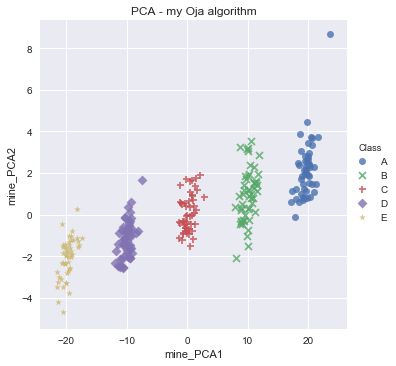

In [179]:
sns.lmplot("mine_PCA1", "mine_PCA2", hue="Class", 
           markers=["o","x","+","D","*"], data=d, fit_reg=False)
sns.plt.title("PCA - my Oja algorithm")

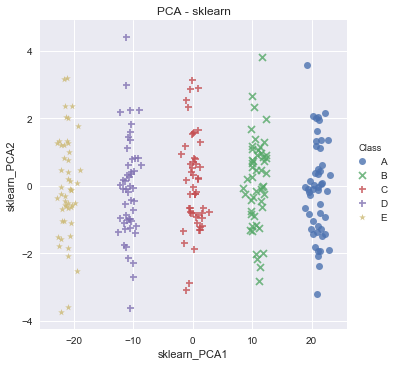

In [180]:
sns.lmplot("sklearn_PCA1", "sklearn_PCA2", hue="Class", 
           markers=["o","x","+","+","*"], data=d, fit_reg=False)
sns.plt.title("PCA - sklearn")

## Run Oja code on AWS

*Re-launch all of the above computations on AWS. Include the following with your submission: a) screenshot with the output for each question, and b) a screenshot with the results of running the following two commands on your instance.*

I ran the code on EC2 by first transferring the file using Git, and then by running a Jupyter Notebook server locally on the EC2 instance, setting up an SSH tunnel from my local Mac to the EC2 instance - pointing port 8157 on my local machine to port 8888 on the EC2 instance, and then viewing the HTML (generated on the EC2 instance) in my local browser.

Here's the address bar showing the use of the tunneled port 8157.

![firstpage](ec2_1.png)

Here are screen shots of all of the Oja code running on EC2.

![firstpage](ec2_3.png)

![firstpage](ec2_4.png)

![firstpage](ec2_5.png)

![firstpage](ec2_6.png)

![firstpage](ec2_7.png)

![firstpage](ec2_8.png)

![firstpage](ec2_9.png)

![firstpage](ec2_10.png)

![firstpage](ec2_11.png)

![firstpage](ec2_12.png)

Finally, here's the output of running history after setting formatting. I had two SSH terminal connections open so I include images from running history on both sessions.

![firstpage](history1.png)

![firstpage](history2.png)